In [1]:
from jax import config
config.update('jax_enable_x64', True)
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import jax.random as jr
import pandas as pd

from uncprop.utils.experiment import Experiment
from uncprop.models.elliptic_pde.experiment import PDEReplicate

base_dir = Path('/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper')

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
key = jr.key(2353223)
key, key_experiment = jr.split(key)

experiment_name = 'pde_experiment'
experiment_settings = {
    'name': experiment_name,
    'base_out_dir': base_dir / 'out' / experiment_name,
    'num_reps': 1,
    'base_key': key_experiment,
    'Replicate': PDEReplicate,
    'write_to_file': True,
}

setup_kwargs = {
    'n_design': 30
}

def make_subdir_name(setup_kwargs, run_kwargs):
    n = setup_kwargs['n_design']
    return f'n_design_{n}'

pde_experiment = Experiment(subdir_name_fn=make_subdir_name, 
                            **experiment_settings)



Creating new output directory: /Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/out/pde_experiment


In [3]:
results, failed_reps = pde_experiment(setup_kwargs=setup_kwargs)

Creating experiment sub-directory: /Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/out/pde_experiment/n_design_30
Running replicate 0
	Fitting surrogate
	Running samplers
No save_results() methods implemented.
0 of 1 replicates failed.


In [4]:
rep = results[0]
posterior = rep.posterior

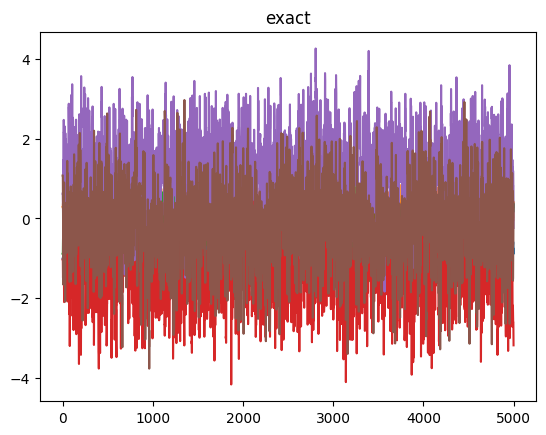

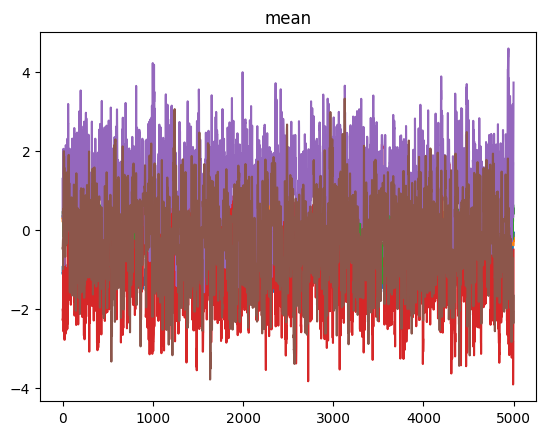

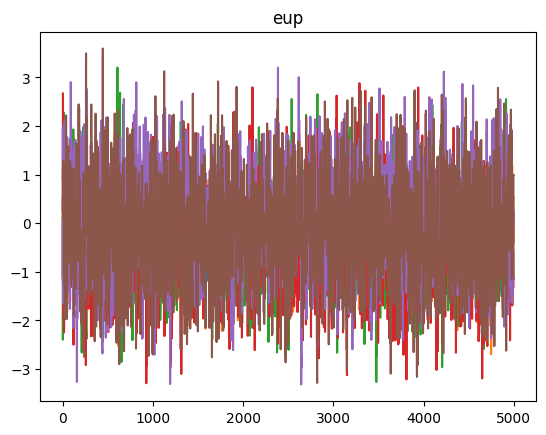

In [5]:
for mcmc_tag in ['exact', 'mean', 'eup']:
    samp = rep.samples[mcmc_tag]
    for i in range(posterior.dim):
        plt.plot(samp[:,i])
        plt.title(mcmc_tag)
    plt.show()

In [6]:
key_prior_samp, key = jr.split(key)

samples = rep.samples
samples['prior'] = posterior.prior.sample(key_prior_samp, n=samples['exact'].shape[0])

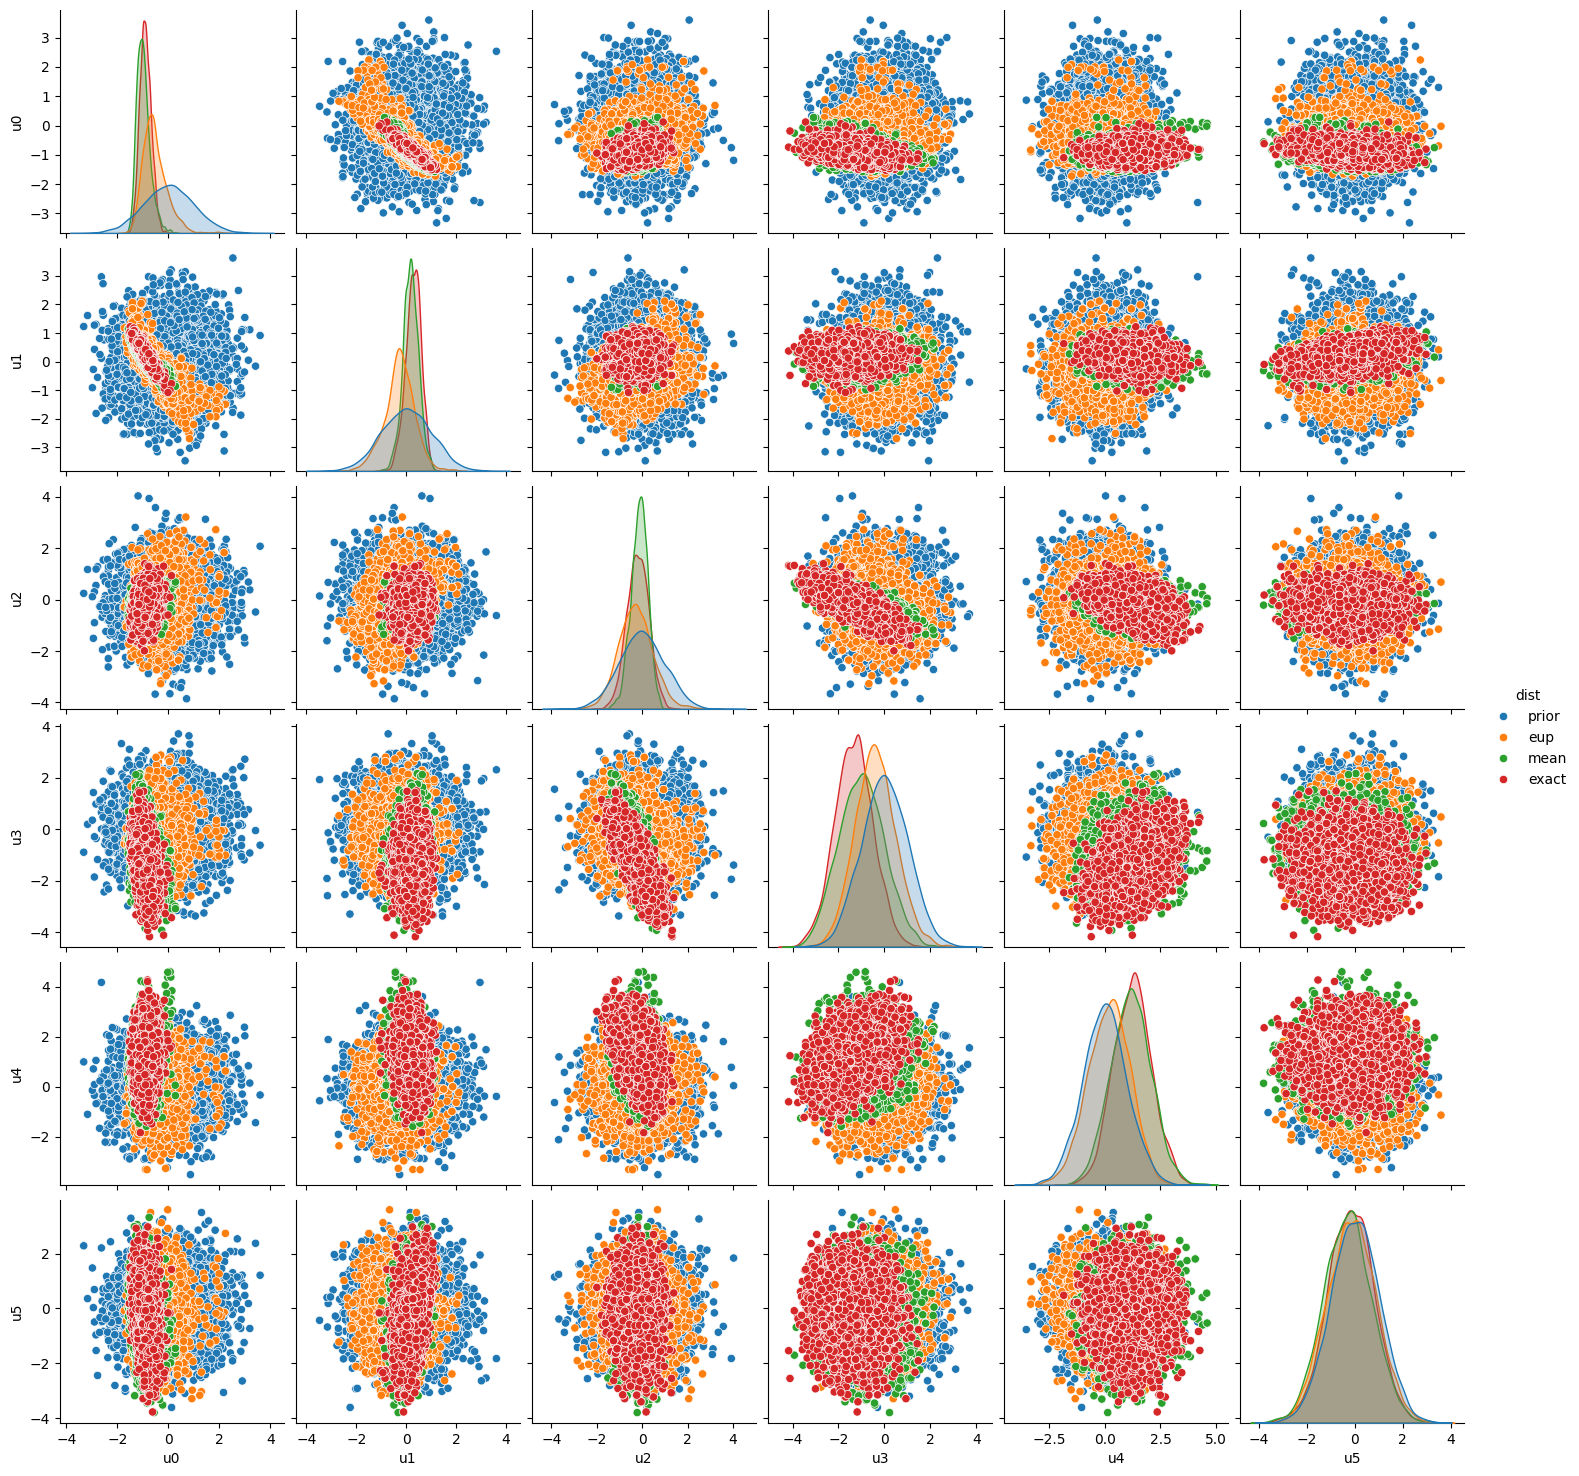

In [7]:
key_subsamp, key = jr.split(key)

dist1_name = 'exact'
dist2_name = 'eup'

dist_names = ['prior', 'eup', 'mean', 'exact']

df_list = []
for name in dist_names:
    df = pd.DataFrame(samples[name], columns=posterior.prior.par_names)
    df['dist'] = name
    df_list.append(df)
samp_df = pd.concat(df_list, ignore_index=True)

# idx = jr.choice(key_subsamp, samp.shape[0], (10_000,))
# post_samp_df = pd.DataFrame(samp[idx], columns=posterior.prior.par_names)

sns.pairplot(samp_df, hue='dist', diag_kind='kde')

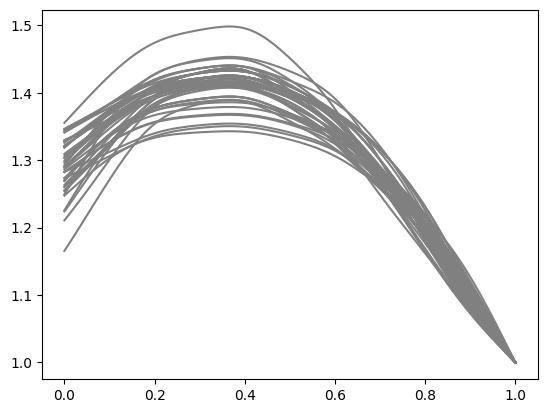

In [8]:
postsamp = samp[-50:,:]
param, log_field, pde_solution, observable = posterior.likelihood.forward_model.forward_with_intermediates(postsamp)
xgrid = posterior.likelihood.forward_model.pde_settings.xgrid

plt.plot(xgrid, pde_solution.T, color='gray')
plt.show()


### Test RFF approximation

In [18]:
from collections.abc import Callable

import jax
import jax.numpy as jnp
from gpjax.gps import _build_fourier_features_fn
from gpjax.kernels.approximations import RFF
from numpyro.distributions import MultivariateNormal

from uncprop.core.surrogate import GPJaxSurrogate
from uncprop.utils.gpjax_multioutput import BatchIndependentGP
from uncprop.core.distribution import GaussianFromNumpyro
from uncprop.custom_types import PRNGKey, Array

surrogate = rep.posterior_surrogate.surrogate
batchgp = rep.batchgp
input = posterior.prior.sample(key, 20)

In [19]:
from uncprop.utils.gpjax_multioutput import _build_batch_basis_funcs, _build_batch_basis_noise_dist

num_rff = 300

basis_fn = _build_batch_basis_funcs(key, surrogate, batchgp, num_rff=300)
dist = _build_batch_basis_noise_dist(surrogate=surrogate,
                                     batchgp=batchgp,
                                     num_rff=300)



test = basis_fn(input)
test.shape

(4, 20, 630)

In [ ]:
def sample_approx_trajectory(basis_fn: Callable, 
                             noise_realization: Array,
                             surrogate: GPJaxSurrogate, 
                             num_rff: int):
    """
    n = number design points
    q = number of output variables
    b = total number of basis functions
    t = number of trajectories being sampled

    Phi and K are used to denote the RFF and canonical bases, respectively.

    Args:
        noise_realization:
            shape (n_traj, dim_batch, dim_basis), as returned by the distriution returned
            by `_build_batch_basis_noise_dist()`.
        
    """

    X = surrogate.design.X 
    Y = surrogate.design.y # (n, q)
    kernel = surrogate.gp.prior.kernel

    # separate into two noise sources
    dim_rff_basis = 2 * num_rff
    rff_weight = noise_realization[:, :, :dim_rff_basis] # (m, q, dim_rff)
    likelihood_noise = noise_realization[:, :, dim_rff_basis:] # (m, q, n)

    # basis functions evaluated at design points
    Phi_X, K_X = basis_fn(X) # (q, n, b_rff), (q, m, n)
    Phi_X_w = Phi_X[None] @ rff_weight[..., None]
    Phi_X_w = Phi_X_w.squeeze(-1) # (t, q, n)

    def trajectory(x: Array) -> Array:
        """
        input is shape (m, d) [m points in d dimensions]

        Returns:
            Array of shape (t, q, m), consisting of the t trajectories
            of the batch of q independent GPs evaluated at the m 
            input points.
        """
        Phi_x, K_x = basis_fn(x) # (q, m, b_rff), (q, m, n)

        Phi_x_w = Phi_x[None] @ rff_weight[..., None]
        Phi_x_w = Phi_x_w.squeeze(-1) # (t, q, m)

        # construct canonical weights
        Y_term = Y.T[None] + likelihood_noise - Phi_X_w # (t, q, n)
        canonical_term = K_X[None] @ Y_term[..., None]  # (t, q, n)
        result = Phi_x_w - canonical_term               # (t, q, n)
                
        return result

In [ ]:
X = surrogate.design.X 
Y = surrogate.design.y # (n, q)
kernel = surrogate.gp.prior.kernel

# weights
dim_rff_basis = 2 * num_rff
rff_weight = noise_realization[:, :, :dim_rff_basis] # (m, q, dim_rff)
likelihood_noise = noise_realization[:, :, dim_rff_basis:]

# bases
basis_x = basis_fn(input) # (dim_out, m, n_basis)
basis_X = basis_fn(X) # (dim_out, n, n_basis)

Phi_x = basis_x[:, :, :dim_rff_basis]
Phi_X = basis_X[:, :, :dim_rff_basis]

Phi_X_w = Phi_X[None] @ rff_weight[..., None]
Phi_x_w = Phi_x[None] @ rff_weight[..., None]

Phi_X_w = Phi_X_w.squeeze(-1) # (t, q, n)
Phi_x_w = Phi_x_w.squeeze(-1) # (t, q, m)

# construct canonical weights
kxX_P, _ = surrogate._compute_kxX_P(input, surrogate.P, surrogate.design) # (q, m, n)
Y_term = Y.T[None] + likelihood_noise - Phi_X_w # (t, q, n)

canonical_term = kxX_P[None] @ Y_term[..., None] # (t, q, n)

result = Phi_x_w - canonical_term # (t, q, n)

In [ ]:
def approx_trajectory():
    pass

In [20]:
noise_realization = dist.sample(key, 3)

In [ ]:
Y = surrogate.design.y # (n, q)
X = surrogate.design.X 
kernel = surrogate.gp.prior.kernel

# weights
dim_rff_basis = 2 * num_rff
rff_weight = noise_realization[:, :, :dim_rff_basis] # (m, q, dim_rff)
likelihood_noise = noise_realization[:, :, dim_rff_basis:]

# bases
basis_x = basis_fn(input) # (dim_out, m, n_basis)
basis_X = basis_fn(X) # (dim_out, n, n_basis)

Phi_x = basis_x[:, :, :dim_rff_basis]
Phi_X = basis_X[:, :, :dim_rff_basis]

Phi_X_w = Phi_X[None] @ rff_weight[..., None]
Phi_x_w = Phi_x[None] @ rff_weight[..., None]

Phi_X_w = Phi_X_w.squeeze(-1) # (t, q, n)
Phi_x_w = Phi_x_w.squeeze(-1) # (t, q, m)

# construct canonical weights
kxX_P, _ = surrogate._compute_kxX_P(input, surrogate.P, surrogate.design) # (q, m, n)
Y_term = Y.T[None] + likelihood_noise - Phi_X_w # (t, q, n)

canonical_term = kxX_P[None] @ Y_term[..., None] # (t, q, n)

result = Phi_x_w - canonical_term # (t, q, n)

In [ ]:
result.shape

(3, 4, 30)

In [29]:
rff_weight.shape

(3, 4, 600)

In [17]:
Phi_x.shape

(4, 20, 630)

In [15]:
rff_weight.shape

(3, 4, 300)

In [37]:
test = Phi_x[None] @ rff_weight[..., None]

In [38]:
test.shape

(3, 4, 20, 1)

In [ ]:

Phi_x_w = Phi_x @ rff_weight

kxX_P, _ = surrogate._compute_kxX_P(input, surrogate.P, surrogate.design) # (q, m, n)

print(rff_weight.shape)
print(likelihood_noise.shape)

In [ ]:
from gpjax.gps import _build_fourier_features_fn
from gpjax.kernels.approximations import RFF

key, key_rff, key_prior = jr.split(key, 3)
surrogate = rep.posterior_surrogate.surrogate
gp = surrogate.gp
U = posterior.prior.sample(key_prior, 20)

In [ ]:
approximate_kernel = RFF(
    base_kernel=gp.prior.kernel, num_basis_fns=300, key=key_rff, 
)

In [ ]:
fourier_feature_fn = _build_fourier_features_fn(gp.prior, 300, key_rff)

In [ ]:
test = fourier_feature_fn(U)

In [ ]:
def sample_basis_weights():

In [ ]:
        # sample fourier features
        fourier_feature_fn = _build_fourier_features_fn(self.prior, num_features, key)

        fourier_weights = jr.normal(key, [num_samples, 2 * num_features])

        obs_var = self.likelihood.obs_stddev.value**2
        Kxx = self.prior.kernel.gram(train_data.X)
        Sigma = Dense(add_jitter(Kxx.to_dense(), obs_var + self.jitter))
        eps = jnp.sqrt(obs_var) * jr.normal(key, [train_data.n, num_samples])
        y = train_data.y - self.prior.mean_function(train_data.X)
        Phi = fourier_feature_fn(train_data.X)
        canonical_weights = solve(
            Sigma,
            y + eps - jnp.inner(Phi, fourier_weights),
        )  # [N, B]

In [ ]:
key, key_rff = jr.split(key)
surrogate = rep.posterior_surrogate.surrogate
traj = surrogate.gp.sample_approx(num_samples=10_000, train_data=rep.design, num_features=300, key=key_rff)


### Test

In [ ]:
key_init, key_run, key_surrogate = jr.split(key, 3)

rep = PDEReplicate(key_init)
rep(key_run, write_to_file=False)
posterior = rep.posterior
forward_model = posterior.likelihood.forward_model

In [ ]:
test = {'a': 1, 'b': 2}
keys = [3, 4]

for key, (k, v) in zip(keys, test.items()):
    print(key, k, v)

In [ ]:
from uncprop.models.elliptic_pde.surrogate import fit_pde_surrogate


design, surrogate, history = fit_pde_surrogate(key=key_surrogate,
                                               posterior=posterior,
                                               n_design=60,
                                               design_method='lhc')

In [ ]:
key_prior, key = jr.split(key)

xtest = posterior.prior.sample(key_prior, 200)
f_true = forward_model(xtest)
pred = surrogate(xtest)

In [ ]:
for i in range(f_true.shape[1]):
    sns.scatterplot(x=f_true[:,i], y=pred.mean[i], color='blue')
    plt.errorbar(f_true[:,i], pred.mean[i], yerr=pred.stdev[i], fmt='none', ecolor='blue', alpha=0.5)
    plt.plot(f_true[:,i], f_true[:,i], 'r--', label="Ground truth")
    plt.xlabel('true')
    plt.ylabel('surrogate')
    plt.legend()
    plt.title(f'KL mode {i+1}')
    plt.show()